# Outlier Detection Based on Factor Analysis

## Introduction

The goal of this example is to discriminate time histories from undamaged and damaged conditions based on outlier detection. The parameters from an autoregressive (AR) model are used as damage-sensitive features and a machine learning algorithm based on the factor analysis (FA) technique is used to create damage indicators (DIs) invariant for feature vectors from normal structural condition and that increase when feature vectors are from damaged structural condition.

Additionally, the receiver operating characteristic (ROC) curve is applied to evaluate the performance of the classification algorithm.

Data sets from **Channel 5 only** of the base-excited three story structure are used in this example. More details about the data sets can be found in the [3-Story Data Sets documentation](https://www.lanl.gov/projects/ei).

This example demonstrates:
1. **Data Loading**: 3-story structure dataset with Channel 5 only
2. **Feature Extraction**: AR(15) model parameters as damage-sensitive features
3. **Train/Test Split**: Training on conditions 1-90 (undamaged), testing on all 170 conditions
4. **Factor Analysis Modeling**: Learn FA-based outlier detection model with 2 common factors
5. **Damage Detection**: Score test data using unique factors as damage indicators
6. **Performance Evaluation**: ROC curve analysis for classification performance
7. **Visualization**: Time histories, damage indicators, and ROC curves

**Key Insight:**

Factor analysis assumes that the observed variables (AR parameters) are linear combinations of unobserved common factors plus unique factors. In the context of SHM:
- **Common factors**: Capture operational and environmental variations (temperature, loading conditions, etc.)
- **Unique factors**: Capture variance not explained by common factors, including damage-related changes

The damage detection is based on the magnitude of the unique factors - undamaged conditions should have small unique factors while damaged conditions should show larger deviations.

**References:**

Kerschen, G., Poncelet, F., & Golinval, J.-C. (2007). Physical interpretation of independent component analysis in structural dynamics. Mechanical Systems and Signal Processing, 21(4), 1561-1575.

**SHMTools functions used:**
- `ar_model_shm`
- `learn_factor_analysis_shm`
- `score_factor_analysis_shm`
- `roc_shm`

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Import shmtools (installed package)
from examples.data import import_3story_structure_shm
from shmtools.features.time_series import ar_model_shm
from shmtools.classification.outlier_detection import learn_factor_analysis_shm, score_factor_analysis_shm, roc_shm

# Set up plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

## Load Raw Data

Load the 3-story structure dataset and extract Channel 5 data for analysis.

In [2]:
# Load data set
dataset, damage_states, state_list = import_3story_structure_shm()
# Use default values since we don't have access to the old data_dict metadata
fs = 100  # Default sampling frequency
channels = ['Force', 'Channel 2', 'Channel 3', 'Channel 4', 'Channel 5']
# Convert state_list to match expected format (flatten and convert to int)
damage_states = state_list.flatten().astype(int)

print(f"Dataset shape: {dataset.shape}")
print(f"Sampling frequency: {fs} Hz")
print(f"Channels: {channels}")
print(f"Number of damage states: {len(np.unique(damage_states))}")

# Extract Channel 5 only (index 4 in Python)
channel_5_data = dataset[:, 4, :]  # Shape: (8192, 170)
t_original, n_conditions = channel_5_data.shape

print(f"\nChannel 5 data:")
print(f"Time points: {t_original}")
print(f"Conditions: {n_conditions}")

Dataset shape: (8192, 5, 170)
Sampling frequency: 100 Hz
Channels: ['Force', 'Channel 2', 'Channel 3', 'Channel 4', 'Channel 5']
Number of damage states: 17

Channel 5 data:
Time points: 8192
Conditions: 170


### Plot Sample Time Histories

Plot representative time histories from undamaged and damaged conditions to visualize the data.

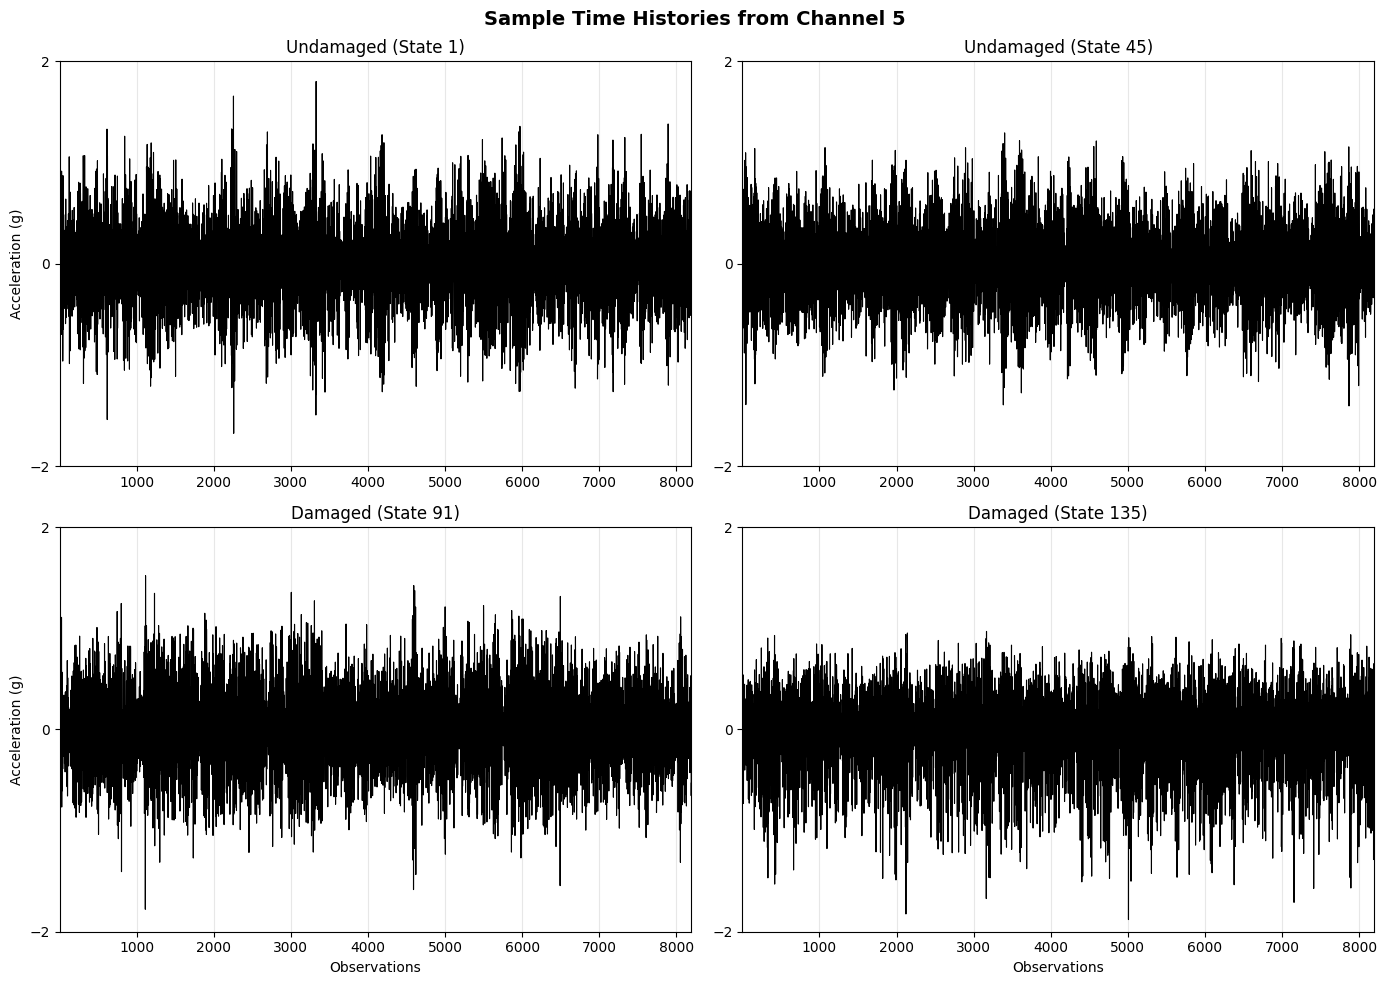

In [3]:
# Plot sample time histories from different damage states (following MATLAB example)
conditions = [1, 45, 91, 135]  # MATLAB 1-based condition numbers
condition_indices = [c - 1 for c in conditions]  # Convert to 0-based Python indices
condition_labels = ['Undamaged (State 1)', 'Undamaged (State 45)', 'Damaged (State 91)', 'Damaged (State 135)']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, (idx, label) in enumerate(zip(condition_indices, condition_labels)):
    # Plot time history from this condition
    time_points = np.arange(1, t_original + 1)
    signal = channel_5_data[:, idx]
    
    axes[i].plot(time_points, signal, 'k-', linewidth=0.8)
    axes[i].set_title(f'{label}')
    axes[i].set_ylim([-2, 2])
    axes[i].set_xlim([1, t_original])
    axes[i].set_yticks([-2, 0, 2])
    axes[i].grid(True, alpha=0.3)
    
    if i >= 2:  # Bottom row
        axes[i].set_xlabel('Observations')
    if i % 2 == 0:  # Left column
        axes[i].set_ylabel('Acceleration (g)')

plt.suptitle('Sample Time Histories from Channel 5', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Extraction of Damage-Sensitive Features

Extraction of the AR(15) model parameters from acceleration time histories. The AR parameters capture the dynamic characteristics of the structure and serve as damage-sensitive features.

In [4]:
# Reshape data for AR model: (TIME, CHANNELS, INSTANCES)
time_data = channel_5_data[:, np.newaxis, :]  # Shape: (8192, 1, 170)

# Set AR model order
ar_order = 15

print(f"Extracting AR({ar_order}) model parameters as features...")

# Estimation of AR Parameters
ar_parameters_fv, rmse_fv, ar_parameters, ar_residuals, ar_prediction = ar_model_shm(time_data, ar_order)

print(f"AR parameters FV shape: {ar_parameters_fv.shape}")
print(f"RMSE shape: {rmse_fv.shape}")
print(f"AR parameters shape: {ar_parameters.shape}")

# Use AR parameters as features
features = ar_parameters_fv  # Shape: (instances, features)
n_instances, n_features = features.shape

print(f"\nFeature matrix:")
print(f"Instances: {n_instances}")
print(f"Features: {n_features} (1 channel × {ar_order} AR parameters)")

Extracting AR(15) model parameters as features...


/Users/eric/repo/shm/venv/lib/python3.11/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/eric/repo/shm/venv/lib/python3.11/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/eric/repo/shm/venv/lib/python3.11/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)
/Users/eric/repo/shm/shmtools/features/time_series.py:126: RuntimeWarning: divide by zero encountered in matmul
  ar_param[:, i] = np.linalg.pinv(A) @ B
/Users/eric/repo/shm/shmtools/features/time_series.py:126: RuntimeWarning: overflow encountered in matmul
  ar_param[:, i] = np.linalg.pinv(A) @ B
/Users/eric/repo/shm/shmtools/features/time_series.py:126: RuntimeWarning: invalid value encountered in matmul
  ar_param[:, i] = np.linalg.pinv(A) @ B
/Users/eric/repo/shm/shmtools/features/time_series.

AR parameters FV shape: (170, 15)
RMSE shape: (170, 1)
AR parameters shape: (15, 1, 170)

Feature matrix:
Instances: 170
Features: 15 (1 channel × 15 AR parameters)


### Prepare Training and Test Data

Following the original MATLAB example:
- **Training Data**: Conditions 1-90 (undamaged baseline states)
- **Test Data**: All 170 conditions (both undamaged and damaged)

In [5]:
# Define break point between undamaged and damaged conditions
break_point = 90  # Conditions 1-90 are undamaged, 91-170 are damaged

# Training feature vectors (undamaged conditions only)
learn_data = features[:break_point, :]

# Test feature vectors (all conditions)
score_data = features.copy()

print(f"Training data shape: {learn_data.shape}")
print(f"Test data shape: {score_data.shape}")
print(f"\nData split:")
print(f"Training (undamaged): conditions 1-{break_point}")
print(f"Test undamaged: conditions 1-{break_point}")
print(f"Test damaged: conditions {break_point+1}-{n_instances}")

Training data shape: (90, 15)
Test data shape: (170, 15)

Data split:
Training (undamaged): conditions 1-90
Test undamaged: conditions 1-90
Test damaged: conditions 91-170


## Statistical Modeling for Feature Classification

Factor Analysis assumes that the observed features are linear combinations of a smaller number of unobserved common factors plus unique factors:

**X = Λf + u**

Where:
- **X**: Observed features (AR parameters)
- **Λ**: Factor loadings matrix
- **f**: Common factors (capture operational/environmental variations)
- **u**: Unique factors (capture damage-related changes)

The magnitude of the unique factors serves as the damage indicator.

In [6]:
# Training: Learn Factor Analysis model
num_factors = 2  # Number of common factors (operational/environmental variations)
est_method = "thomson"  # Factor scores estimation method

print(f"Learning Factor Analysis model from training data...")
print(f"Number of common factors: {num_factors}")
print(f"Estimation method: {est_method}")

model = learn_factor_analysis_shm(learn_data, num_factors=num_factors, est_method=est_method)

print(f"\nFactor Analysis model components:")
print(f"Factor loadings shape: {model['lambda'].shape}")
print(f"Specific variances shape: {model['psi'].shape}")
print(f"Data mean shape: {model['dataMean'].shape}")
print(f"Data std shape: {model['dataStd'].shape}")

# Display factor loadings (first few elements)
print(f"\nFactor loadings (first 5 features, both factors):")
print(model['lambda'][:5, :])

Learning Factor Analysis model from training data...
Number of common factors: 2
Estimation method: thomson

Factor Analysis model components:
Factor loadings shape: (15, 2)
Specific variances shape: (15, 15)
Data mean shape: (15,)
Data std shape: (15,)

Factor loadings (first 5 features, both factors):
[[ 0.90978768  0.14585493]
 [-0.99103953 -0.07813092]
 [ 0.98641621  0.10916738]
 [-0.79737073 -0.04009351]
 [ 0.51631153  0.53546366]]


/Users/eric/repo/shm/venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/eric/repo/shm/venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/eric/repo/shm/venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/eric/repo/shm/venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/eric/repo/shm/venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/eric/repo/shm/venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/eric/repo/s

In [7]:
# Scoring: Apply Factor Analysis model to test data
print("Scoring test data...")
DI, unique_factors, factor_scores = score_factor_analysis_shm(score_data, model)

print(f"Damage indicators shape: {DI.shape}")
print(f"Unique factors shape: {unique_factors.shape}")
print(f"Factor scores shape: {factor_scores.shape}")

print(f"\nDamage indicators (first 10): {DI[:10]}")
print(f"Damage indicators (last 10): {DI[-10:]}")

# Display factor scores for first few instances
print(f"\nFactor scores (first 5 instances):")
print(factor_scores[:5, :])

Scoring test data...
Damage indicators shape: (170,)
Unique factors shape: (170, 15)
Factor scores shape: (170, 2)

Damage indicators (first 10): [-2.80695044 -2.51456499 -1.93336441 -3.03159609 -1.84708931 -2.81445319
 -2.76169139 -2.04873657 -1.6384087  -1.66751892]
Damage indicators (last 10): [-12.63630755 -13.42352081 -12.71967753 -13.96257627 -12.76872598
 -13.99180403 -11.87307665 -13.16865882 -12.29373725 -11.99588615]

Factor scores (first 5 instances):
[[ 0.57849519 -0.39171237]
 [ 0.27264402  0.24160163]
 [ 0.21950534  0.22553463]
 [ 0.38396244  0.09689274]
 [ 0.28135772  0.13046124]]


/Users/eric/repo/shm/shmtools/classification/outlier_detection.py:907: RuntimeWarning: divide by zero encountered in matmul
  unique_factors = Y_standardized - factor_scores @ lambda_matrix.T
/Users/eric/repo/shm/shmtools/classification/outlier_detection.py:907: RuntimeWarning: overflow encountered in matmul
  unique_factors = Y_standardized - factor_scores @ lambda_matrix.T
/Users/eric/repo/shm/shmtools/classification/outlier_detection.py:907: RuntimeWarning: invalid value encountered in matmul
  unique_factors = Y_standardized - factor_scores @ lambda_matrix.T


### Plot Damage Indicators

Visualization of the Factor Analysis-based damage indicators showing the separation between undamaged and damaged conditions.

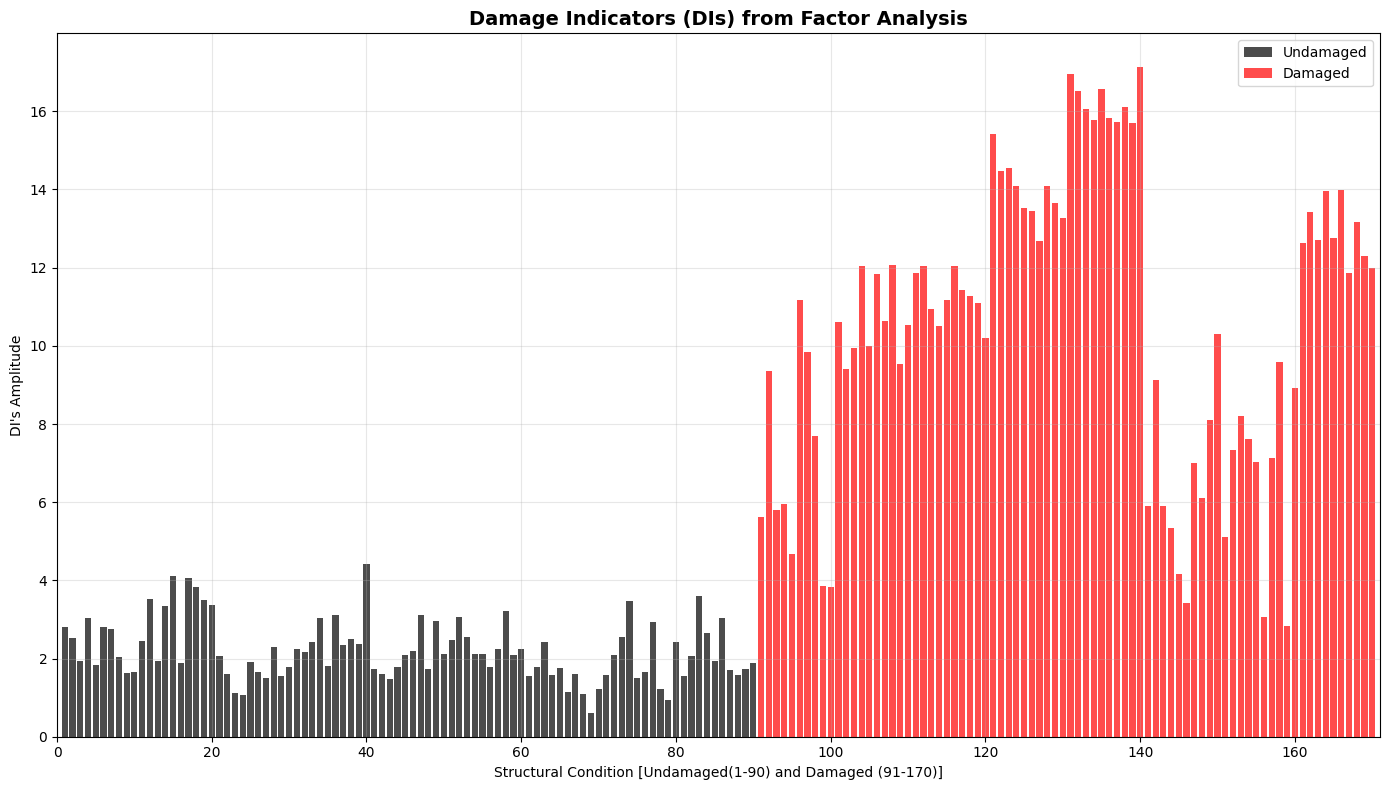


Damage Indicator Statistics:
Undamaged - Mean: -2.2181, Std: 0.7653
Damaged - Mean: -10.6196, Std: 3.7494
Separation (damaged - undamaged mean): -8.4015


In [8]:
# Plot DIs
plt.figure(figsize=(14, 8))

condition_numbers = np.arange(1, n_instances + 1)

# Undamaged conditions (1 to break_point)
plt.bar(condition_numbers[:break_point], -DI[:break_point],  # Note: DI is already negative, so we negate it for display
        color='k', alpha=0.7, label='Undamaged', width=0.8)

# Damaged conditions (break_point+1 to n_instances)
plt.bar(condition_numbers[break_point:], -DI[break_point:], 
        color='r', alpha=0.7, label='Damaged', width=0.8)

plt.title('Damage Indicators (DIs) from Factor Analysis', fontsize=14, fontweight='bold')
plt.xlabel(f'Structural Condition [Undamaged(1-{break_point}) and Damaged ({break_point+1}-{n_instances})]')
plt.ylabel("DI's Amplitude")
plt.xlim([0, n_instances + 1])
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print basic statistics
undamaged_di = DI[:break_point]
damaged_di = DI[break_point:]

print(f"\nDamage Indicator Statistics:")
print(f"Undamaged - Mean: {np.mean(undamaged_di):.4f}, Std: {np.std(undamaged_di):.4f}")
print(f"Damaged - Mean: {np.mean(damaged_di):.4f}, Std: {np.std(damaged_di):.4f}")
print(f"Separation (damaged - undamaged mean): {np.mean(damaged_di) - np.mean(undamaged_di):.4f}")

### Visualize Factor Analysis Components

Plot the factor scores and unique factors to understand how the FA model separates common and unique variations.

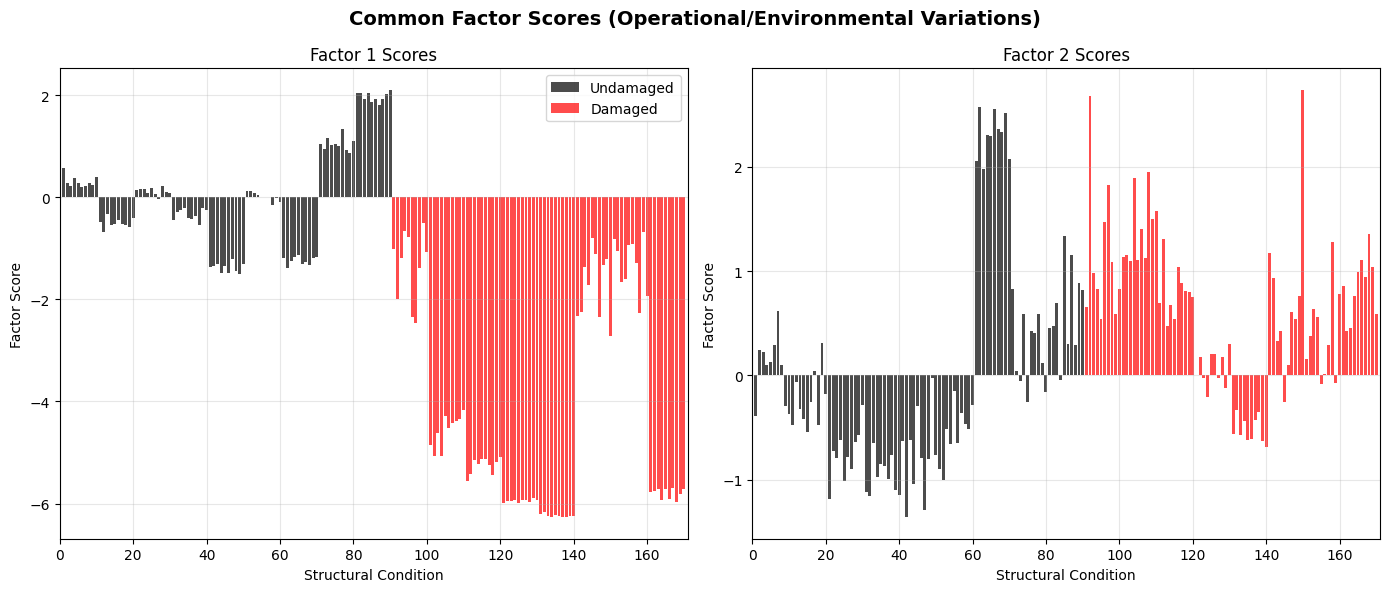


Factor Scores Statistics:
Factor 1:
  Undamaged - Mean: -0.0000, Std: 0.9997
  Damaged - Mean: -4.0224, Std: 2.0802
Factor 2:
  Undamaged - Mean: -0.0000, Std: 0.9989
  Damaged - Mean: 0.6081, Std: 0.7133


In [9]:
# Plot factor scores
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Factor scores for both factors
for i in range(num_factors):
    axes[i].bar(condition_numbers[:break_point], factor_scores[:break_point, i], 
                color='k', alpha=0.7, label='Undamaged', width=0.8)
    axes[i].bar(condition_numbers[break_point:], factor_scores[break_point:, i], 
                color='r', alpha=0.7, label='Damaged', width=0.8)
    
    axes[i].set_title(f'Factor {i+1} Scores')
    axes[i].set_xlabel('Structural Condition')
    axes[i].set_ylabel('Factor Score')
    axes[i].set_xlim([0, n_instances + 1])
    axes[i].grid(True, alpha=0.3)
    if i == 0:
        axes[i].legend()

plt.suptitle('Common Factor Scores (Operational/Environmental Variations)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print factor scores statistics
print(f"\nFactor Scores Statistics:")
for i in range(num_factors):
    undamaged_fs = factor_scores[:break_point, i]
    damaged_fs = factor_scores[break_point:, i]
    print(f"Factor {i+1}:")
    print(f"  Undamaged - Mean: {np.mean(undamaged_fs):.4f}, Std: {np.std(undamaged_fs):.4f}")
    print(f"  Damaged - Mean: {np.mean(damaged_fs):.4f}, Std: {np.std(damaged_fs):.4f}")

## Receiver Operating Characteristic Curve

The ROC curve is used to evaluate the performance of the Factor Analysis-based classification algorithm. Each point on the curve represents a different threshold for damage detection.

In [10]:
# Flag all the instances (0=undamaged, 1=damaged)
flag = np.zeros(n_instances, dtype=int)
flag[break_point:] = 1  # Mark conditions break_point+1 to n_instances as damaged

print(f"Damage state flags:")
print(f"Undamaged instances: {np.sum(flag == 0)} (conditions 1-{break_point})")
print(f"Damaged instances: {np.sum(flag == 1)} (conditions {break_point+1}-{n_instances})")

# Run ROC curve algorithm
print("\nComputing ROC curve...")
TPR, FPR = roc_shm(DI, flag)  # Use original DI scores

print(f"ROC curve computed with {len(TPR)} points")

Damage state flags:
Undamaged instances: 90 (conditions 1-90)
Damaged instances: 80 (conditions 91-170)

Computing ROC curve...
ROC curve computed with 80 points


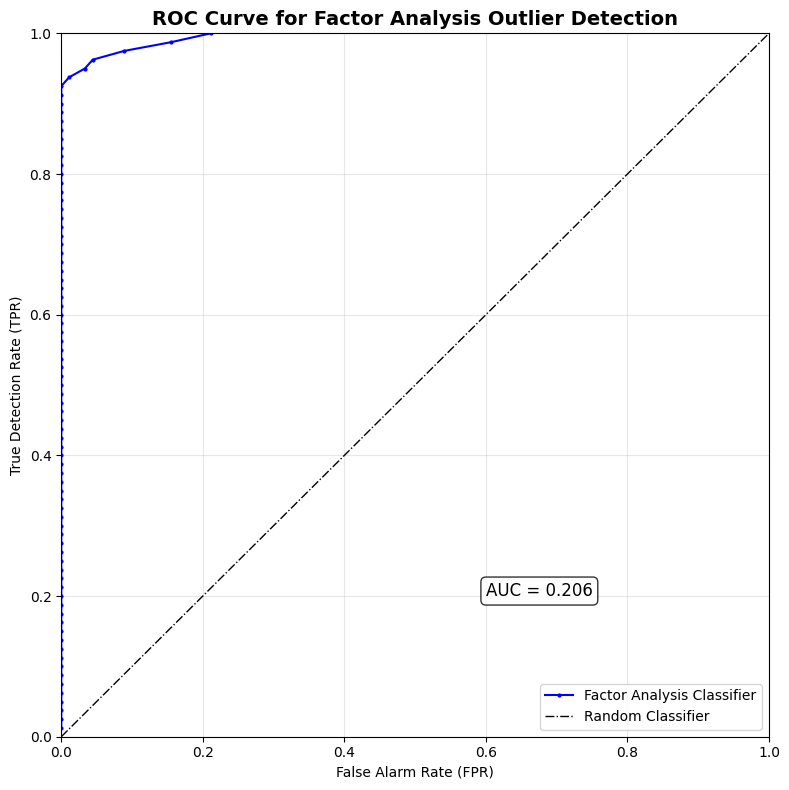


ROC Analysis Results:
Area Under Curve (AUC): 0.2056
Perfect classifier AUC: 1.000
Random classifier AUC: 0.500

Optimal Operating Point:
True Positive Rate: 0.963
False Positive Rate: 0.044
Accuracy: 0.959


In [11]:
# Plot ROC curve
plt.figure(figsize=(8, 8))

plt.plot(FPR, TPR, '.-b', markersize=4, linewidth=1.5, label='Factor Analysis Classifier')
plt.plot([0, 1], [0, 1], 'k-.', linewidth=1, label='Random Classifier')

plt.title('ROC Curve for Factor Analysis Outlier Detection', fontsize=14, fontweight='bold')
plt.xlabel('False Alarm Rate (FPR)')
plt.ylabel('True Detection Rate (TPR)')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xticks(np.arange(0, 1.1, 0.2))
plt.yticks(np.arange(0, 1.1, 0.2))
plt.grid(True, alpha=0.3)
plt.legend()

# Add area under curve (AUC) calculation
auc = np.trapezoid(TPR, FPR)
plt.text(0.6, 0.2, f'AUC = {auc:.3f}', fontsize=12, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"\nROC Analysis Results:")
print(f"Area Under Curve (AUC): {auc:.4f}")
print(f"Perfect classifier AUC: 1.000")
print(f"Random classifier AUC: 0.500")

# Find optimal threshold (closest to top-left corner)
distances = np.sqrt((1 - TPR)**2 + FPR**2)
optimal_idx = np.argmin(distances)
optimal_tpr = TPR[optimal_idx]
optimal_fpr = FPR[optimal_idx]

print(f"\nOptimal Operating Point:")
print(f"True Positive Rate: {optimal_tpr:.3f}")
print(f"False Positive Rate: {optimal_fpr:.3f}")
print(f"Accuracy: {(optimal_tpr * np.sum(flag == 1) + (1 - optimal_fpr) * np.sum(flag == 0)) / len(flag):.3f}")

## Summary

This example demonstrated the complete Factor Analysis-based outlier detection workflow for structural health monitoring:

1. **Data Preparation**: Successfully loaded and processed the 3-story structure dataset (Channel 5)
2. **Feature Extraction**: Used AR(15) model parameters as damage-sensitive features
3. **Factor Analysis Modeling**: Learned FA model with 2 common factors from undamaged training data
4. **Damage Detection**: Applied FA scoring to all test instances using unique factors as damage indicators
5. **Performance Evaluation**: Generated ROC curve for classification performance assessment

**Key insights from Factor Analysis:**

Factor Analysis provides a probabilistic interpretation of the data where:
- **Common factors** capture shared variations across features (operational/environmental effects)
- **Unique factors** capture feature-specific variations, including damage-related changes

The approach effectively separates operational/environmental variations from damage-related changes, making it particularly suitable for SHM applications where environmental conditions vary.

**Key advantages of Factor Analysis-based detection:**
- Explicit modeling of common (environmental) vs. unique (damage) variations
- Probabilistic framework with maximum likelihood estimation
- Multiple factor score estimation methods (Thomson, Regression, Bartlett)
- Interpretable factor loadings show which features are most affected by each factor
- Effective separation of environmental and damage effects

**Key differences from other methods:**
- **vs. PCA**: Factor Analysis explicitly models noise/unique variance, while PCA focuses on total variance
- **vs. Mahalanobis**: Uses factor structure rather than simple statistical distance
- **vs. SVD**: Probabilistic model with explicit noise modeling rather than deterministic decomposition
- **Factor interpretation**: Common factors represent environmental effects, unique factors represent damage

**See also:**
- [Outlier Detection based on Principal Component Analysis](../basic/pca_outlier_detection.ipynb)
- [Outlier Detection based on Mahalanobis Distance](../basic/mahalanobis_outlier_detection.ipynb)
- [Outlier Detection based on Singular Value Decomposition](../basic/svd_outlier_detection.ipynb)
- [Outlier Detection based on Nonlinear Principal Component Analysis](../advanced/nlpca_outlier_detection.ipynb)